# Simple Convolutional Neural Network Model with different number of months

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with loose restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout
from keras.regularizers import L2

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, calculate_metrics

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

In [4]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Preparing outputs common for all models

In [5]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [6]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_loose_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-05-04 00:00:00
Cannot get optimal portfolio for 2023-07-06 00:00:00
Cannot get optimal portfolio for 2023-12-05 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(288, 27)

In [7]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

In [8]:
os.chdir(os.path.expanduser('../data'))

In [9]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [10]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

## Defining models for different number of months

In [11]:
total_ret_list = []
cum_total_ret_list = []

for no_months in range(3, 10):
    print(f'CNN Model for {no_months} months')
    x = []
    for date in days_to_recalculate:
        indicators = data_provider.calculate_principal_component_from_indicators(
            date, periods=no_months, indicators=all_indicators)
        x.append(indicators.values)

    x_pca = np.array(x)
    x_train = x_pca[:val_split]
    x_val = x_pca[val_split:test_split]
    x_test = x_pca[test_split:]

    model_cnn = Sequential((
        Conv1D(32, 3, input_shape=x_train.shape[1:]),
        Flatten(),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=L2(0.3)),
        Dense(y_train.shape[1], activation='softmax')
    ))

    train_and_evaluate_model(model_cnn, x_train, y_train,
                             x_val, y_val, x_test, y_test,
                             verbose=False)

    (total_ret, cum_total_ret) = calculate_returns_for_model(
        model_cnn, x_test, dates_for_test,
        df_returns_test, selected_countries)

    total_ret_list.append(total_ret)
    cum_total_ret_list.append(cum_total_ret)

CNN Model for 3 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Train error: 0.02126208506524563
Val error: 0.021795952692627907
Test error: 0.026043379679322243
Execution time 9.3 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
CNN Model for 4 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Train error: 0.021275371313095093
Val error: 0.021822581067681313
Test error: 0.026158135384321213
Execution time 9.05 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
CNN Model for 5 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Train error: 0.021289126947522163
Val error: 0.02177831530570984
Test error: 0.02621431276202202
Execution time 8.89 seconds
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019183A49F80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
CNN Model for 6 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Train error: 0.021238142624497414
Val error: 0.022066013887524605
Test error: 0.026309778913855553
Execution time 8.86 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
CNN Model for 7 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Train error: 0.021407680585980415
Val error: 0.02229233644902706
Test error: 0.026767384260892868
Execution time 8.94 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
CNN Model for 8 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Train error: 0.021343186497688293
Val error: 0.022283483296632767
Test error: 0.026709221303462982
Execution time 9.1 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
CNN Model for 9 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Train error: 0.021421467885375023
Val error: 0.02237912453711033
Test error: 0.02683185040950775
Execution time 8.96 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


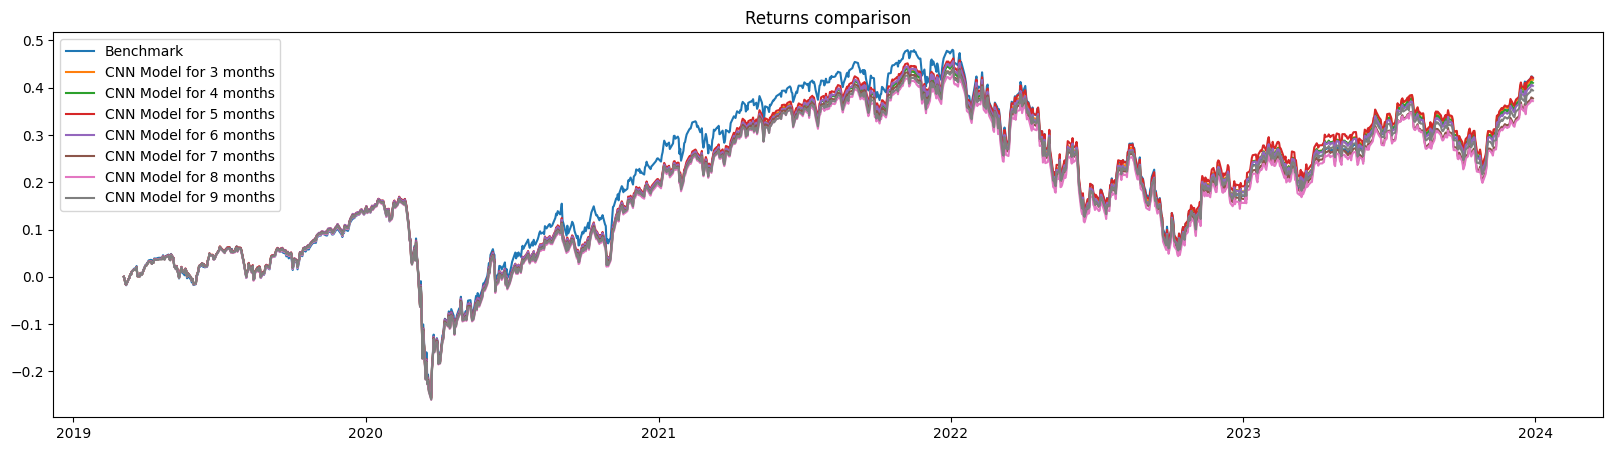

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')

for no_months in range(7):
    plt.plot(cum_total_ret_list[no_months],
             label=f'CNN Model for {no_months+3} months')

plt.legend()
plt.title('Returns comparison')
plt.show()

In [13]:
df_results = pd.DataFrame(columns=['Annual Returns',
                                   'Annual Volatility',
                                   'Annual Sharpe Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')

for no_months in range(7):
    calculate_metrics(total_ret_list[no_months], df_results,
                      f'CNN Model for {no_months+3} months')

df_results

,Annual Returns,Annual Volatility,Annual Sharpe Ratio
Benchmark,0.076754,0.203326,0.377494
CNN Model for 3 months,0.074934,0.200378,0.373963
CNN Model for 4 months,0.073933,0.200173,0.369344
CNN Model for 5 months,0.075589,0.20062,0.37678
CNN Model for 6 months,0.07292,0.1993,0.365882
CNN Model for 7 months,0.068684,0.199046,0.345064
CNN Model for 8 months,0.067783,0.200412,0.33822
CNN Model for 9 months,0.071381,0.199445,0.357898
